# The SIR and SEIR epidemiological models

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Thu Apr  2 00:58:24 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

In [4]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [5]:
from scipy.integrate import odeint
import scipy.integrate as spi
from scipy.interpolate import interp1d


In [6]:
from dataclasses import dataclass, field

In [7]:
from c19.types import SIR, SEIR

In [8]:
import c19.basic_models as cbm
import c19.core_functions as cf
import c19.plotting as cplt
import c19.utils as ut

# SEIR with dead rate temperature and control measures

- Simple SEIR

$$
\frac{dS}{dt} = - \beta S I \\
\frac{dE}{dt} = \beta S I - \sigma E \\
\frac{dI}{dt} = \sigma E - \gamma I \\
\frac{dR}{dt} = \gamma I
$$

- We expand the SEIR model to include de population of deceased. The equations are.

$$
\frac{dS}{dt} = - \frac{\beta}{N} S I \\
\frac{dE}{dt} = \frac{\beta}{N} I - \sigma E \\
\frac{dI}{dt} = \sigma E - \gamma I \\
\frac{dR}{dt} = (1 - \phi) \gamma I \\
\frac{dD}{dt} = \phi \gamma I -g D \\
M =g D \\
P = gD - \lambda P
$$

Here, S, I and R represent the numbers of susceptible, infectious and recovered individuals, respectively. We model mortality using two variables: D represents individuals, who are no longer infectious and on track to die from the effects of the illness, while M models those who have died of the illness; this approach allows us to incorporate the delay between a normal recovery time and the typical time of death. P represents the public perception of risk. It increases when people die, and decays naturally, meaning that perception of risk diminishes over time in the absence of  deaths. P in turn affects the transmission rate $\beta$ (as specified below). $N = S + I + R + D + M$  is the total population (assumed to be constant).

The case fatality proportion (CFP) is $\phi$, and $\gamma$, g and $\lambda$ denote the rates at which individuals leave the I, D and P compartments, respectively; thus:
- $1/gamma$ is the mean infectious period
- $1/g$ is the the mean time from loss of infectiousness to death
- $1/\lambda$ is the mean duration of impact of deaths on public perception

The transmission rate $\beta$ is given by:

$$ \beta(t, P) = \beta_0 e^{-\xi T(t)} (1 - \alpha(t)) (1 - \frac{P(t)}{N})^k$$


In [34]:
N                = 1000
ND               = 200
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma, G = 3, 1./7, 1./5., 1/7 
Beta             = Gamma * R0
Phi              = 0.2
Lamda            = 1 / 10.
k                = 100
I0, E0, D0, P0, RX   = 1E-4, 1E-4, 0, 0.5, 0
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0, RX, D0, P0)


In [35]:
seir2 = cbm.compute_seir2(N, Y0, R0, Gamma, Sigma, Phi, G, Lamda, k,
                  t_range, ts = [(0, 400)], ms=[1.0]) 

In [36]:
def plot_seir2(sir, T, figsize=(10,10), facecolor='LightGrey'):
    """Plot the data on 6 separate curves for S(t), E(t),I(t), R(t), D(t) & P(t) """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, axisbelow=True)
    ax.set_facecolor(facecolor)
    ax.plot(sir.t, sir.S, 'k', alpha=0.5, lw=3, label='Susceptibles')
    ax.plot(sir.t, sir.E, 'b', alpha=0.5, lw=3, label='Expuestos')
    ax.plot(sir.t, sir.I, 'r', alpha=0.5, lw=3, label='Infectados')
    ax.plot(sir.t, sir.R, 'g', alpha=0.5, lw=3, label='Recuperados')
    ax.plot(sir.t, sir.D, 'y', alpha=0.5, lw=3, label='Fatales')
    ax.plot(sir.t, sir.M, 'c', alpha=0.5, lw=3, label='Muertes')
    ax.set_xlabel('Tiempo (días)')
    ax.set_ylabel('Fracción de la población')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title(T)
    plt.show()

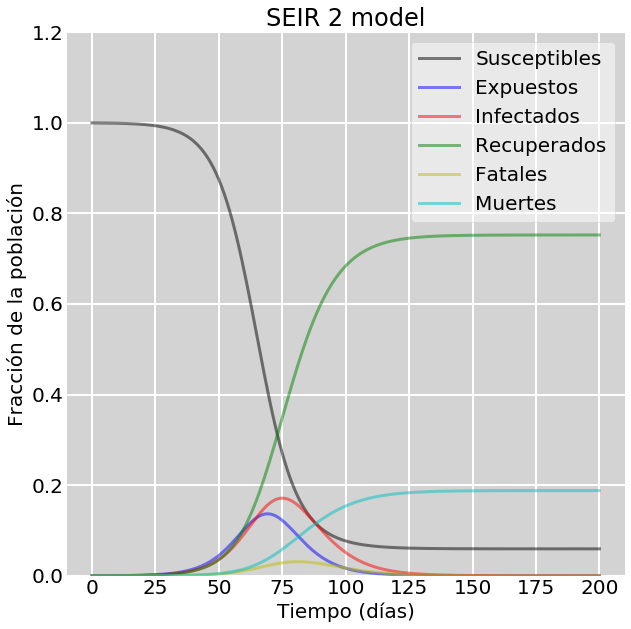

In [37]:
plot_seir2(seir2, T='SEIR 2 model', figsize=(10,10), facecolor='LightGrey')